In [ ]:
#     ### Forces due to gravity acting on the COM
#     g_forceCOM = star.f_COM
#     g_forceCOM = [0.,0.,0.] # we're not taking this into consideration rn.
#     g_forceCOM = np.asarray(g_forceCOM)
#     a_g = g_forceCOM/star.m # Acceleration due to the force acting on the center of mass
#     a = np.asarray(a)
#     a[:,0] += a_g[0] # x component of gravitational acceleration acting on the center of mass
#     a[:,1] += a_g[1] # y component of gravitational acceleration acting on the center of mass
#     a[:,2] += a_g[2] # x component of gravitational acceleration acting on the center of mass
#     return a

In [81]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import gamma
import time
import math
import matplotlib as mp
import scipy as sp
import pylab as py
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation

from ipynb.fs.full.Neutron_Star_SPH_sph import W, gradW, getPairwiseSeparations, getDensity
from ipynb.fs.full.Neutron_Star_SPH_eos import EOS, rho_NS

# Neutron Star Class Code

In [17]:
def getAcc(star):
    """ 
    Calculate the acceleration on each SPH particle given current positions and velocities.
    
    'pos' contains particle coordinates (N x 3 matrix)
    'vel' contains particle velocities (N x 3 matrix)
    returns 'a' containing accelerations (another N x 3 matrix)   
    
    """ 
    # ======================= Extract star properties ======================= #
    m = star.m # m = particle mass
    pos = star.pos # point positions relative to COM
    vel = star.vel # point velocities
    rho = star.rho # star density
    # ======================= Pressure from density, EOS ======================= #
    
    P = star.eos.P(star.rho) # Pressure as a function of density
    
    # ======================= SPH Update ======================================= #
    N = pos.shape[0] # Number of particles
    h = star.h # smoothing length
    dx, dy, dz = getPairwiseSeparations( pos, pos ) # Get pairwise distances
    dWx, dWy, dWz = gradW( dx, dy, dz, h )# Get pairwise gradients
    ax = - np.sum( m * ( np.transpose(P/rho**2) + P.T/rho.T**2 ) * dWx, 1).reshape((N,1)) # Add x Pressure contribution to accelerations
    ay = - np.sum( m * ( np.transpose(P/rho**2) + P.T/rho.T**2 ) * dWy, 1).reshape((N,1)) # Add y Pressure contribution to accelerations
    az = - np.sum( m * ( np.transpose(P/rho**2) + P.T/rho.T**2 ) * dWz, 1).reshape((N,1)) # Add z Pressure contribution to accelerations
    a = np.hstack((ax,ay,az)) # pack together the acceleration components
    # ========================================================================== #
    ##### Extra forces
    lmbda = eos.lmbda(star.mass, star.radius) # external potential force
    a -= lmbda * pos # Add external potential force
    nu = star.nu
    a -= nu * vel # Add viscosity
    return a   

In [28]:
def update_graph(num):
    data=df[df['time']==num]
    graph._offsets3d = (data.x, data.y, data.z)
    title.set_text('3D Test, time={}'.format(num)) 

In [83]:
class NS:
    def __init__(self, tag, eos, mass = 1, radius = 1, num_points = 300,h = 0.05,nu=1):
        """
        NEUTRON STAR OBJECT
        
        A neutron star has the following attributes: 
            - tag, mass, radius, num_points, eos
            
        A point has the following attributes: 
            - position (N x 3), vel (N x 3), acc (N x 3), density (N x 1), pressure (N x 1).        
        
        """
        # Star properties
        self.tag = tag # "Name" of the star, just a string for identification
        self.radius = radius # star radius in km
        self.mass = mass # star mass in solar Masses
        self.eos = eos # equation of state    
        self.num_points = num_points # number of SPH points modeling the star
        self.m = mass/num_points # each point has "mass" m in solar masses (maybe change later to baryon number)
        
        # Star motion
        self.com = [0,0,0] # center of mass is initialized at the origin.
        self.f_COM = [0,0,0]  # at initialization there is no net force acting on the center of mass
        
        #=======================================================#
        # for each point in the star, initialize random positions and velocities.
        np.random.seed(42) # set the random number generator seed
        # randomly select positions and velocities from initialized seed
        self.pos = np.random.randn(self.num_points,3)   # (km) positions of the particles relative to the center of mass (in km)
        self.vel = np.zeros(self.pos.shape)    # (km/s) randomly select positions and velocities positions and velocities are N x 3 matrices.
        self.acc = np.zeros(self.pos.shape)  # (km/s^2) initially we haven't updated the accelerations of those random points for the star.
        self.points_position = np.copy(self.pos) # true position, this will be corrected when we move the center of mass. 
        
        # Viscosity and Smoothing Length
        self.nu = nu # viscosity
        self.h = h # smoothing length 
        self.rho = getDensity(self.pos, self.pos, self.m, self.h)
        #=======================================================#
        ##### INITIALIZATION STEP --> Random points initialize to initial density
        dt = 0.05
        tEnd = 18
        t = 0      # current time of the simulation
        Nt = int(np.ceil(tEnd/dt)) # number of timesteps
        
        for i in range(Nt): # Star Simulation Time Iteration Main Loop
            self.vel += self.acc * dt/2 # (1/2) kick # adds acceleration
            self.pos += self.vel * dt # particle motion
            self.acc = getAcc(self) # get new Nx3 matrix of accelerations based on new pos,v
            self.vel += self.acc * dt/2 # (1/2) kick 
            t += dt # update time
            if t % dt*100==0: # print every 100 timesteps
                if False:
                    print("Star initialization.  timestep: " , t)
            self.rho = getDensity(self.pos, self.pos, self.m, self.h) # get updated density for each point based on m, h. 
        print("-------success!\n", "\nSTAR OBJECT. Name: '" + self.tag + "', Mass: " + str(self.mass) + " SMs, "+ "Radius: " + str(self.radius) + " km", "\n")
        return None

    def getPosition(self):
        """ Returns the true positions of all the points in the star, which are corrcted for the center of mass location."""
        position = np.copy(self.pos)
        COM = self.com
        position[:,0] += COM[0]
        position[:,1] += COM[1]
        position[:,2] += COM[2]
        self.points_position  = position # track the true particle locations
        return position
    
    def move_com(self, com_new): 
        """
        Takes in new coordinates of the center of mass of the star in km. 
        Changes the location of the star's center of mass 
        """
        if len(com_new) != 3:
            raise ValueError("The New Center of Mass you entered for NS is not 3 dimensions.")
        self.com = com_new

    def modify_com_force(self, f_COM_new): 
        """ Modifies the force acting on the center of mass of the star. """
        if len(f_COM_new) != 3:
            raise ValueError("The force acting on the COM that you entered for the NS is not in 3 dimensions.")
        self.f_COM = f_COM_new
    
    def update_motion(self, com_pos_new): 
        """ 
        This function will update the positions of the points for one timestep 
        based on the force acting on the center of gravity of the star. 
        
        The points of one star only recieve center of gravity info and react to each other
        They do not interact directly with the points of the other star.
        
        pos_array, vel_array, acc_array must be arrays with 3 elements (x,y,z) """
        self.pos = self.pos[:] + com_pos_new
        return None
    
    def __str__(self):
        return "\nSTAR OBJECT. Name: '" + self.tag + "', Mass: " + str(self.mass) + " SMs, "+ "Radius: " + str(self.radius) + " km" 
    def get_relative_position(self):
        """  This function returns an N x 3 array of the star's points positions relative to the center of mass """
        return self.pos
    def get_velocity(self):
        """ This function returns the star's velocity.    """
        return self.vel
    def get_mass(self):
        """ This function returns the star's overall mass . """
        return self.mass

In [73]:
Mass = 10
Radius = 2
points = 700

eos = EOS('standard') 
star_1 = NS("star_1", eos,Mass,Radius,num_points = points) # Initialize star

-------success!
 
STAR OBJECT. Name: 'star_1', Mass: 10 SMs, Radius: 2 km 



# EOS / Model Testing

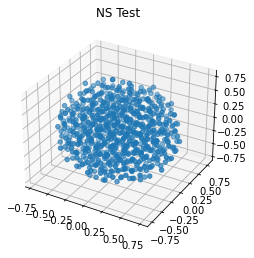

In [70]:
a = np.asarray(star_1.pos) # Points for plotting
points_count = len(a) # Total number of points
points_per_timestep = star_1.num_points # assign all points to the same timestep in the movie
t = np.array([np.ones(points_per_timestep)*i for i in range(int(points_count/points_per_timestep))]).flatten() 
df = pd.DataFrame({"time": t ,"x" : a[:,0], "y" : a[:,1], "z" : a[:,2]})
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
title = ax.set_title('NS Test')
data=df[df['time']==0]
graph = ax.scatter(data.x, data.y, data.z)
ani = matplotlib.animation.FuncAnimation(fig, update_graph, 1, interval=10, blit=False)
plt.show()
ani.save("eos_test" + str(Mass) + "_" + str(Radius) +"_" +  str(points) + ".mp4")

In [ ]:
# ======================================================================== #
nu_ = 1 # viscosity
eos = EOS('standard') 
##

Smooth = [1.5] # vary the smoothing length
L = [(4,10)]  # vary the (mass, radius)
points_list = [4000] # vary the number of SPH points

# ======================================================================== # 
for i in L:
    for pts in points_list:
        for h_ in Smooth:
            Mass = i[0]
            Radius = i[1]
            points = pts
            star_1 = NS("star_1" + str(Mass) + "_" + str(Radius) +"_" +  str(points), eos,Mass,Radius,num_points = points,h = h_, nu = nu_) # Initialize star
            a = np.asarray(star_1.pos) # Points for plotting
            points_count = len(a) # Total number of points
            points_per_timestep = star_1.num_points # assign all points to the same timestep in the movie
            t = np.array([np.ones(points_per_timestep)*i for i in range(int(points_count/points_per_timestep))]).flatten() 
            df = pd.DataFrame({"time": t ,"x" : a[:,0], "y" : a[:,1], "z" : a[:,2]})
            fig = plt.figure()
            ax = fig.add_subplot(111, projection='3d')
            title = ax.set_title('NS Test')
            data=df[df['time']==0]
            graph = ax.scatter(data.x, data.y, data.z)
            ani = matplotlib.animation.FuncAnimation(fig, update_graph, 1, interval=10, blit=False)
            plt.show()
            ani.save("eos_test" + str(Mass) + "_" + str(Radius) +"_" +  str(points) +"h" + str(h_) + ".mp4")

In [ ]:
#L = [(0.25,5),(0.25,2),(0.25,3),(1,1),(1,2),(1,3),(3,1),(3,2),(3,3)] # small test
#L = [(2,10),(3,10),(2,15),(3,15),(2,20),(3,20)] # more accurate